# CNN vs CNN-transformer in extreme values

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
from collections import OrderedDict
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math
from matplotlib.colors import TwoSlopeNorm
import Models

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse
from astropy.io import fits
import copy

import glob
import pickle
import CNN
import os
import sys
import PIL
import data_loader
import sys, os

In [2]:
base_path = os.getcwd()
data_path  = os.path.join(base_path, 'data')
data_cube_path = os.path.join(data_path, 'saury2014','cubes')
fcnm_path = os.path.join(data_path, 'saury2014','fcnm')
rhi_path = os.path.join(data_path, 'saury2014','RHI')
print(data_cube_path)
print(fcnm_path)
print(rhi_path)

C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\cubes
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\fcnm
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\RHI


In [3]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x 101)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = os.path.join(data_cube_path, training_data_file_q0)
training_data_file_q1 = os.path.join(data_cube_path, training_data_file_q1)
training_data_file_q2 = os.path.join(data_cube_path, training_data_file_q2)
training_data_file_q3 = os.path.join(data_cube_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = os.path.join(rhi_path, rhi_file_q0)
rhi_file_q1 = os.path.join(rhi_path, rhi_file_q1)
rhi_file_q2 = os.path.join(rhi_path, rhi_file_q2)
rhi_file_q3 = os.path.join(rhi_path, rhi_file_q3)

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = os.path.join(fcnm_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(fcnm_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(fcnm_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(fcnm_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\cubes\Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\fcnm\fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\RHI\R_map_n01_pw02_vs12_512px_quarter_0_noise.fits


In [4]:
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

In [5]:
dictt = {}
# cube 3
num=512*512
for i in range(0, num):
    index=i
    row_index = index//512
    column_index = index%512
    dictt[i] = (cube3[:,row_index, column_index], [fcnm_data3[row_index, column_index], rhi_data3[row_index, column_index]], [0, row_index, column_index])


## models

In [6]:
cnn =  CNN.spectra_cnn_small(num_output=2,
                             in_channels=1,
                             input_row = 2,
                             input_column=101,
                             drop_out_rate=0,
                             lpe=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn=cnn.to(device)
checkpoint = torch.load(f'./checkpoint/poly_concate_cnn.pth',map_location=device)
cnn.load_state_dict(checkpoint['net'])
cnn.eval()

spectra_cnn_small(
  (dropout): Dropout(p=0, inplace=False)
  (conv1): Conv2d(1, 72, kernel_size=(2, 3), stride=(1, 1))
  (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(72, 64, kernel_size=(1, 10), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): ModuleList(
    (0): Conv2d(1, 72, kernel_size=(2, 3), stride=(1, 1))
    (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(72, 64, kernel_size=(1, 10), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 56, kernel_size=(1, 3), stride=(1, 1))
    (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(56, 48, kernel_size=(1, 10), stride=(1, 1))
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, 

In [7]:
cnn_transformer =  Models.cnn_transformer_small(num_output=2,
                             in_channels=1,
                             input_row = 1,
                             input_column=101,
                             drop_out_rate=0,
                             lpe=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_transformer=cnn_transformer.to(device)
checkpoint = torch.load(f'./checkpoint/learnable_PEV.pth',map_location=device)
cnn_transformer.load_state_dict(checkpoint['net'])
cnn_transformer.eval()

cnn_transformer_small(
  (pos_encoder): PositionalEncoding()
  (conv1): Conv2d(1, 72, kernel_size=(1, 3), stride=(1, 1))
  (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(72, 64, kernel_size=(1, 10), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 56, kernel_size=(1, 3), stride=(1, 1))
  (bn3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(56, 48, kernel_size=(1, 10), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 40, kernel_size=(1, 3), stride=(1, 1))
  (bn5): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(40, 32, kernel_size=(1, 10), stride=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(32, 16, kernel_size

## Top 10 biggest Fcnm in ground truth 

In [8]:
Fcnm_d = {}
d = copy.deepcopy(dictt)
num=512*512
dell = []
for i in range(0, 10):
    big = 0
    for x, (key, value) in enumerate(d.items()):
        current_fcnm = value[1][0]
        spectra = value[0]
        if(key not in dell and current_fcnm not in dell):
            if(current_fcnm>=big):
                big  = current_fcnm
                Fcnm_d[i] = (spectra,current_fcnm)
                k = key
    dell.append(k)
    dell.append(big)

In [9]:
ground_truth_fcnm = []
cnn_fcnm = []
for i in range (0, len(Fcnm_d)):
    spectra, Fcnm = Fcnm_d[i]
    poly = spectra**2
    spectra = np.vstack((spectra, poly))
    spectra = spectra.reshape(1,1, 2,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_fcnm.append(Fcnm)
    cnn_fcnm.append(abs(cnn(spectra)[0][0].cpu()).detach().numpy())

In [10]:
ground_truth_fcnm = []
prediction_fcnm = []
for i in range (0, len(Fcnm_d)):
    spectra, Fcnm = Fcnm_d[i]
    spectra = spectra.reshape(1,1, 1,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_fcnm.append(Fcnm)
    prediction_fcnm.append(abs(cnn_transformer(spectra)[0][0].cpu()).detach().numpy())

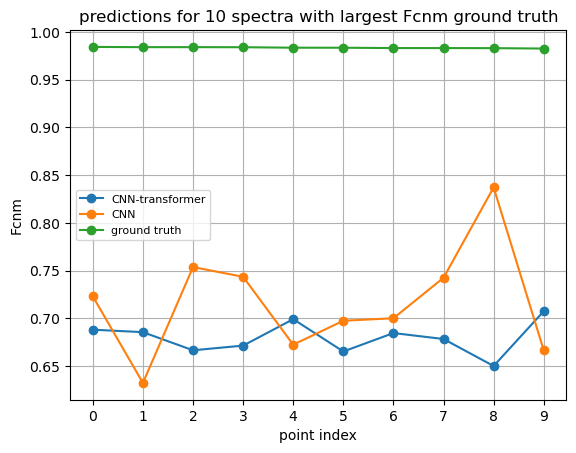

In [11]:
plt.plot(prediction_fcnm, label='CNN-transformer',marker='o')
plt.plot(cnn_fcnm, label='CNN',marker='o')
plt.plot(ground_truth_fcnm, label='ground truth',marker='o')
plt.grid()
plt.grid()
plt.title(f'predictions for 10 spectra with largest Fcnm ground truth')
plt.xlabel('point index')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel('Fcnm')
plt.grid()
plt.legend(prop={'size': 8})

## Top 10 smallest Fcnm in ground truth 

In [12]:
Fcnm_d = {}
d = copy.deepcopy(dictt)
num=512*512
dell = []
for i in range(0, 10):
    small = 100
    for x, (key, value) in enumerate(d.items()):
        current_fcnm = value[1][0]
        spectra = value[0]
        if(key not in dell and current_fcnm not in dell):
            if(current_fcnm<=small):
                small  = current_fcnm
                Fcnm_d[i] = (spectra,current_fcnm)
                k = key
    dell.append(k)
    dell.append(big)

In [13]:
ground_truth_fcnm = []
cnn_fcnm = []
for i in range (0, len(Fcnm_d)):
    spectra, Fcnm = Fcnm_d[i]
    poly = spectra**2
    spectra = np.vstack((spectra, poly))
    spectra = spectra.reshape(1,1, 2,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_fcnm.append(Fcnm)
    cnn_fcnm.append(abs(cnn(spectra)[0][0].cpu()).detach().numpy())

In [14]:
ground_truth_fcnm = []
prediction_fcnm = []
for i in range (0, len(Fcnm_d)):
    spectra, Fcnm = Fcnm_d[i]
    spectra = spectra.reshape(1,1, 1,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_fcnm.append(Fcnm)
    prediction_fcnm.append(abs(cnn_transformer(spectra)[0][0].cpu()).detach().numpy())

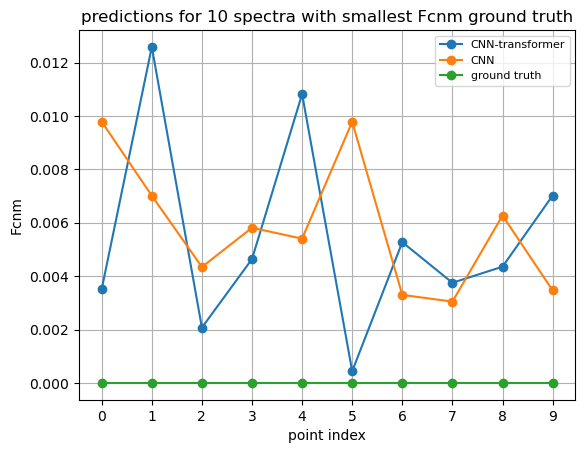

In [15]:
plt.plot(prediction_fcnm, label='CNN-transformer',marker='o')
plt.plot(cnn_fcnm, label='CNN',marker='o')
plt.plot(ground_truth_fcnm, label='ground truth',marker='o')
plt.grid()
plt.grid()
plt.title(f'predictions for 10 spectra with smallest Fcnm ground truth')
plt.xlabel('point index')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel('Fcnm')
plt.grid()
plt.legend(prop={'size': 8})

## Top 10 largest Rhi in ground truth 

In [16]:
Rhi_d = {}
d = copy.deepcopy(dictt)
num=512*512
dell = []
for i in range(0, 10):
    big = 0
    for x, (key, value) in enumerate(d.items()):
        current_rhi = value[1][1]
        spectra = value[0]
        if(key not in dell and current_rhi not in dell):
            if(current_rhi>=big):
                big  = current_rhi
                Rhi_d[i] = (spectra,current_rhi)
                k = key
    dell.append(k)
    dell.append(big)

In [17]:
ground_truth_rhi = []
cnn_rhi = []
for i in range (0, len(Rhi_d)):
    spectra, rhi = Rhi_d[i]
    poly = spectra**2
    spectra = np.vstack((spectra, poly))
    spectra = spectra.reshape(1,1, 2,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_rhi.append(rhi)
    cnn_rhi.append(abs(cnn(spectra)[0][1].cpu()).detach().numpy())

In [18]:
ground_truth_rhi = []
prediction_rhi = []
for i in range (0, len(Rhi_d)):
    spectra, rhi = Rhi_d[i]
    spectra = spectra.reshape(1,1, 1,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_rhi.append(rhi)
    prediction_rhi.append(abs(cnn_transformer(spectra)[0][1].cpu()).detach().numpy())

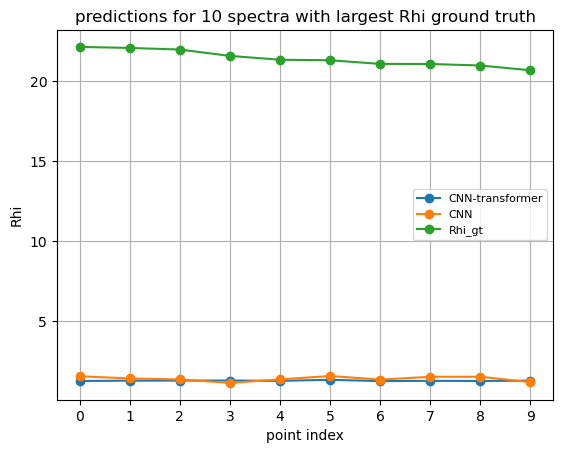

In [19]:
plt.plot(prediction_rhi, label='CNN-transformer',marker='o')
plt.plot(cnn_rhi, label='CNN',marker='o')
plt.plot(ground_truth_rhi, label='Rhi_gt',marker='o')
plt.grid()
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.grid()
plt.title(f'predictions for 10 spectra with largest Rhi ground truth')
plt.xlabel('point index')
plt.ylabel('Rhi')
plt.grid()
plt.legend(prop={'size': 8})

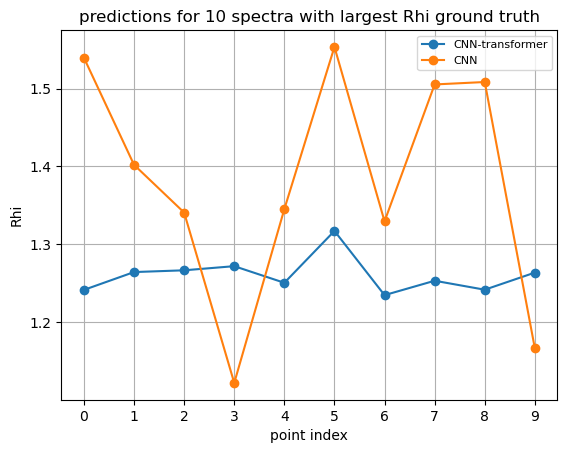

In [20]:
plt.plot(prediction_rhi, label='CNN-transformer',marker='o')
plt.plot(cnn_rhi, label='CNN',marker='o')
plt.grid()
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.grid()
plt.title(f'predictions for 10 spectra with largest Rhi ground truth')
plt.xlabel('point index')
plt.ylabel('Rhi')
plt.grid()
plt.legend(prop={'size': 8})

## Top 10 smallest Rhi in ground truth 

In [21]:
Rhi_d = {}
d = copy.deepcopy(dictt)
num=512*512
dell = []
for i in range(0, 10):
    small = 10000
    for x, (key, value) in enumerate(d.items()):
        current_rhi = value[1][1]
        spectra = value[0]
        if(key not in dell and current_rhi not in dell):
            if(current_rhi<=small):
                small  = current_rhi
                Rhi_d[i] = (spectra,current_rhi)
                k = key
    dell.append(k)
    dell.append(big)

In [22]:
ground_truth_rhi = []
prediction_rhi = []
for i in range (0, len(Rhi_d)):
    spectra, rhi = Rhi_d[i]
    spectra = spectra.reshape(1,1, 1,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_rhi.append(rhi)
    prediction_rhi.append(abs(cnn_transformer(spectra)[0][1].cpu()).detach().numpy())

In [23]:
ground_truth_rhi = []
cnn_rhi = []
for i in range (0, len(Rhi_d)):
    spectra, rhi = Rhi_d[i]
    poly = spectra**2
    spectra = np.vstack((spectra, poly))
    spectra = spectra.reshape(1,1, 2,-1).astype(np.float32)
    spectra = torch.from_numpy(spectra)
    spectra = spectra.to(device)
    ground_truth_rhi.append(rhi)
    cnn_rhi.append(abs(cnn(spectra)[0][1].cpu()).detach().numpy())

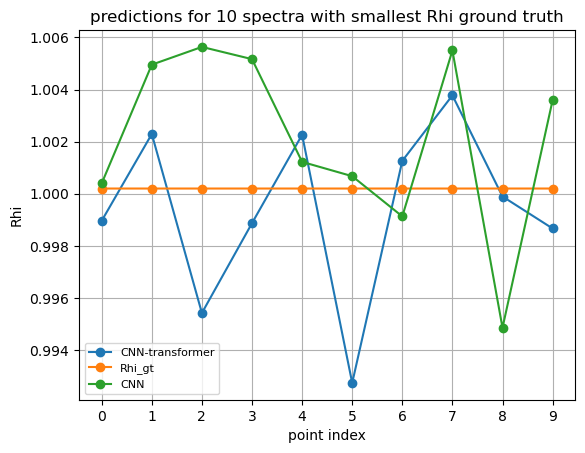

In [24]:
plt.plot(prediction_rhi, label='CNN-transformer',marker='o')
plt.plot(ground_truth_rhi, label='Rhi_gt',marker='o')
plt.plot(cnn_rhi, label='CNN',marker='o')
plt.grid()
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.grid()
plt.title(f'predictions for 10 spectra with smallest Rhi ground truth')
plt.xlabel('point index')
plt.ylabel('Rhi')
plt.grid()
plt.legend(prop={'size': 8})